## LangGraph 자세히 알아보기
인터넷 검색툴을 결합한 Agent 만들기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

### 상태 설정

In [2]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

### 도구 노드 구축

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool_node = ToolNode(tools)

/tmp/ipykernel_31731/2074672630.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


tool node란...

```python
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

```

### LLM 설정

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}


### 그래프 구축

In [6]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

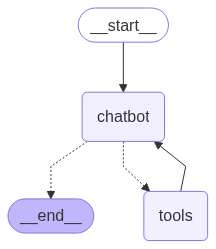

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 인터넷 검색이 필요한 질문

In [8]:
graph.invoke({"messages": {"role": "user", "content": "지금 한국 대통령은 누구야?"}})

{'messages': [HumanMessage(content='지금 한국 대통령은 누구야?', additional_kwargs={}, response_metadata={}, id='6ab293ed-dbc9-4c40-ae9d-ac19f7a4d6a5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_84cvk4iNxMak5TNL7LsTIsoQ', 'function': {'arguments': '{"query":"현재 한국 대통령"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 87, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--065da749-26f8-4bc5-92f3-23edee7112e4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '현재 한국 대통령'}, 'id': 'call_84cvk4iNxMak5TNL7LsTIsoQ', 'type': 'tool_call'}]

### LLM이 답할 수 있는 질문

In [9]:
graph.invoke({"messages": {"role": "user", "content": "마이크로소프트가 어떤 회사야?"}})

{'messages': [HumanMessage(content='마이크로소프트가 어떤 회사야?', additional_kwargs={}, response_metadata={}, id='b868974b-7367-44b1-ac56-488f38a42fe1'),
  AIMessage(content='마이크로소프트(Microsoft)는 미국의 다국적 기술 회사로, 소프트웨어, 하드웨어, 전자제품 및 서비스 분야에서 활동하고 있습니다. 1975년 빌 게이츠와 폴 앨런에 의해 설립되었으며, 본사는 워싱턴주 레드몬드에 위치하고 있습니다.\n\n주요 제품과 서비스로는 다음과 같은 것들이 있습니다:\n\n1. **운영 체제**: Microsoft Windows는 개인용 컴퓨터에서 가장 널리 사용되는 운영 체제입니다.\n2. **오피스 소프트웨어**: Microsoft Office는 워드, 엑셀, 파워포인트 등 다양한 생산성 도구를 포함합니다.\n3. **클라우드 서비스**: Microsoft Azure는 클라우드 컴퓨팅 플랫폼으로, 기업들이 데이터 저장 및 애플리케이션 호스팅을 할 수 있도록 지원합니다.\n4. **게임**: Xbox는 마이크로소프트의 비디오 게임 콘솔 브랜드로, 다양한 게임과 엔터테인먼트 서비스를 제공합니다.\n5. **기타 제품**: Surface 시리즈의 태블릿 및 노트북, LinkedIn과 같은 소셜 네트워크 서비스, 그리고 다양한 개발 도구와 API도 제공합니다.\n\n마이크로소프트는 기술 혁신과 사회적 책임을 강조하며, 다양한 산업에 걸쳐 디지털 전환을 지원하는 데 중점을 두고 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 304, 'prompt_tokens': 89, 'total_tokens': 393, 'completion_tokens_details': {'accepted_prediction_tokens': 0, '